In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd

In [2]:
def calculate_preemption_durations(trace_data, time_interval_minutes=5, time_window=180):
    """
    计算抢占时长。

    Args:
        trace_data (list): 存储每个时间戳存活节点数量的数组。
        time_interval_minutes (int): trace中每个时间戳代表的时间间隔（分钟）。

    Returns:
        list: 所有计算出的抢占时长列表（以分钟为单位）。
    """
    # 抢占事件发生的时间点列表（以数组索引为单位）
    preemption_events_indices = []
    for i in range(1, len(trace_data)):
        if trace_data[i] < trace_data[i - 1]:
            preemption_events_indices.append(i)
    
    if not preemption_events_indices:
        return []

    # 抢占持续时长列表
    preemption_durations = []
    current_duration_start_index = None
    
    # 将一小时转换为数组索引
    one_hour_in_indices = time_window // time_interval_minutes

    for i, event_index in enumerate(preemption_events_indices):
        is_first_in_duration = False

        # 判断抢占事件A：其前一小时没有发生抢占
        if current_duration_start_index is None:
            # 检查这个抢占事件前一小时是否有其他抢占
            prev_preemptions = [idx for idx in preemption_events_indices if idx < event_index and event_index - idx <= one_hour_in_indices]
            if not prev_preemptions:
                current_duration_start_index = event_index
                is_first_in_duration = True
        
        # 如果不是该次持续时长的第一个事件，检查与前一个抢占的时间间隔是否超过一小时
        if not is_first_in_duration:
            prev_event_index = preemption_events_indices[i - 1]
            if event_index - prev_event_index > one_hour_in_indices:
                # 间隔超过一小时，说明上一个持续时长结束了
                # 记录持续时长，并开始一个新的
                preemption_durations.append((prev_event_index - current_duration_start_index)*time_interval_minutes)
                current_duration_start_index = event_index

        # 判断抢占事件B：其后一小时没有发生抢占
        # 检查当前事件后一小时内是否有其他抢占
        next_preemptions = [idx for idx in preemption_events_indices if idx > event_index and idx - event_index <= one_hour_in_indices]
        if not next_preemptions:
            if current_duration_start_index is not None:
                duration_in_indices = event_index - current_duration_start_index
                preemption_durations.append(duration_in_indices*time_interval_minutes)
                current_duration_start_index = None

    # 如果最后一个持续时长在循环结束前没有被记录，则记录它
    if current_duration_start_index is not None:
        last_event_index = preemption_events_indices[-1]
        preemption_durations.append((last_event_index - current_duration_start_index)*time_interval_minutes)

    return preemption_durations


In [3]:
def plot_cdf(durations):
    """
    绘制累积分布函数（CDF）曲线。

    Args:
        durations (list): 抢占时长列表。
    """
    if not durations:
        print("No preemption durations to plot.")
        return

    # 1. 对抢占时长进行排序
    sorted_durations = np.sort(durations)

    # 2. 计算CDF值
    y_values = np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)

    # 3. 绘制CDF曲线
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_durations, y_values, marker='.', linestyle='-', markersize=8)
    
    plt.title('CDF of Preemption Duration')
    plt.xlabel('Preemption Duration (minutes)')
    plt.ylabel('Cumulative Distribution')
    plt.grid(True)
    plt.yticks(np.arange(0, 1.1, 0.1))
    
    plt.show()


In [4]:
def plot_trace_cdf(path):
    with open(path) as f1:
        f1_content = f1.read()
    f1_json = json.loads(f1_content)

    dummy_trace = f1_json['data']

    durations = calculate_preemption_durations(dummy_trace)
    print(f"Calculated preemption durations (minutes): {durations}")

    if durations:
        plot_cdf(durations)
    else:
        print("No valid preemption durations found in the trace.")

Calculated preemption durations (minutes): [15, 445, 5, 0, 305, 730, 5, 390, 10, 130, 15, 70, 5, 5, 390, 10, 35, 80, 95, 170, 465, 430, 50]


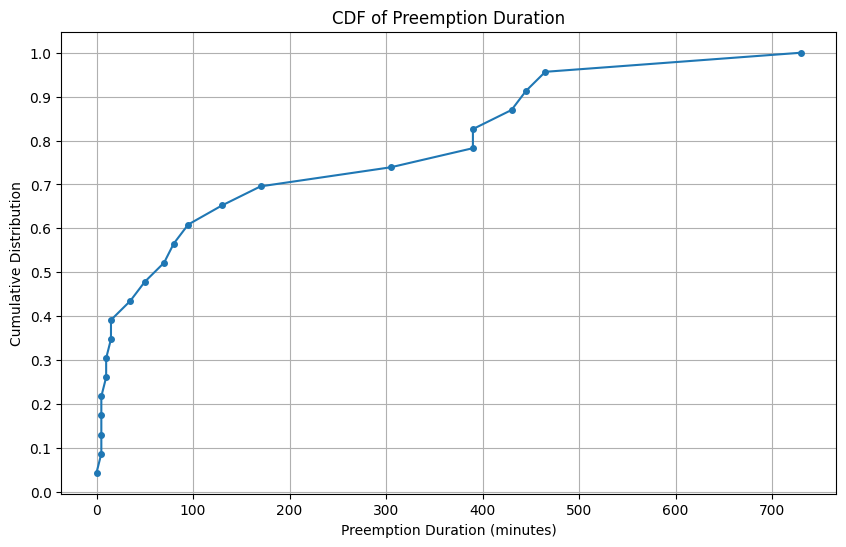

In [44]:
plot_trace_cdf("./traces/preemption/4-node/aws-08-03-2023/us-east-1f_v100_1.json")

Calculated preemption durations (minutes): [215, 10, 205, 0, 455, 5, 0, 0, 0, 235, 240, 0, 310, 105, 10, 360, 250, 5, 520, 5, 45, 55, 440, 610, 695, 5, 405, 280, 10, 160, 10, 0, 110, 925]


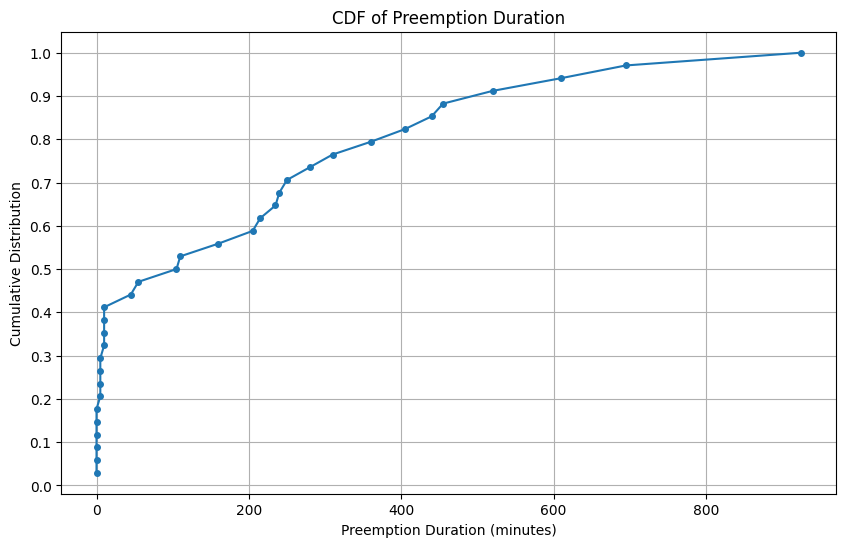

In [38]:
plot_trace_cdf("./traces/preemption/4-node/aws-08-03-2023/us-west-2c_v100_1.json")

Calculated preemption durations (minutes): [65, 275, 0, 225, 305, 65, 0, 370, 0, 0, 95, 180, 0, 0, 45, 390, 370, 0, 0, 0, 0, 180, 175, 0, 35, 0, 0, 275, 0, 0, 35, 65, 0, 0, 230, 500, 0, 0, 80, 180, 230, 145, 0, 0, 0, 275, 160, 240, 0, 80, 0, 0, 145, 290, 50, 50, 160, 0, 80, 260, 180, 340, 165, 0, 115, 45, 0, 480, 515, 0, 0, 175, 95, 95, 130, 50, 50, 210, 0, 320, 470, 500, 0, 35, 0, 0, 420, 0, 165, 0, 0, 30, 190, 290, 0, 770, 0, 160, 0, 80, 0]


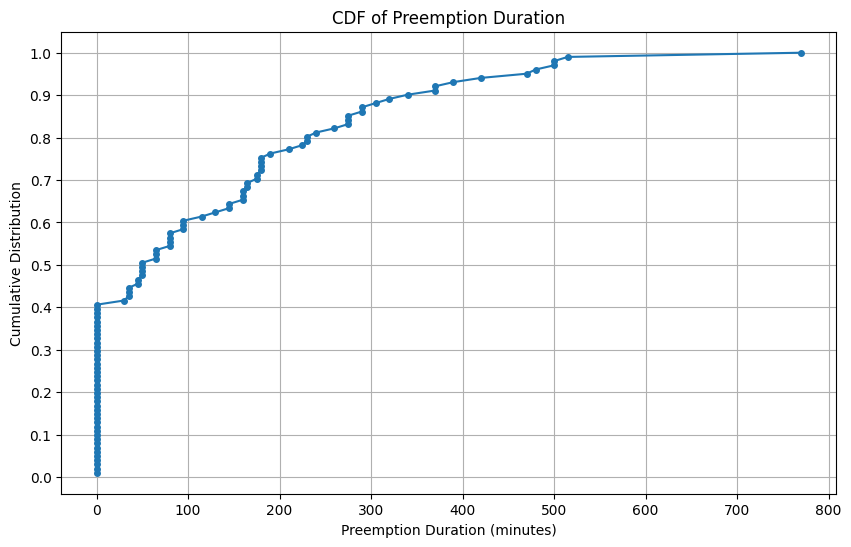

In [39]:
plot_trace_cdf("./traces/availability/1-node/aws-02-15-2023/us-east-1a_v100_1.json")

Calculated preemption durations (minutes): [50, 0, 230, 130, 0, 175, 50, 95, 0, 0, 0, 0, 45, 0, 0, 85, 240, 275, 440, 65, 35, 80, 0, 0, 65, 0, 145, 0, 0, 100, 30, 195, 0, 0, 270, 30, 0, 0, 0, 0, 165, 195, 0, 115, 95, 0, 0, 515, 845, 890, 0, 30, 210, 130, 210, 50, 100, 0, 0, 420, 470, 0, 0, 0, 0, 175, 0, 100, 95, 0, 150, 210, 35, 0, 65, 0, 0, 0, 0, 35, 0, 0, 0, 290, 450, 0, 225, 210, 0, 245, 0, 110, 615, 0, 370, 0, 225, 0, 80, 160, 0, 80, 0, 0, 0, 65, 0, 165, 0, 115, 85, 65, 405, 0, 0, 565, 0, 95, 470, 0, 325, 370, 0, 0, 195, 0, 0, 0, 340, 355, 80, 95, 0, 0, 0, 320, 230, 0, 0, 0, 95, 160, 0, 160, 335, 365, 0, 0, 0, 0, 0, 0]


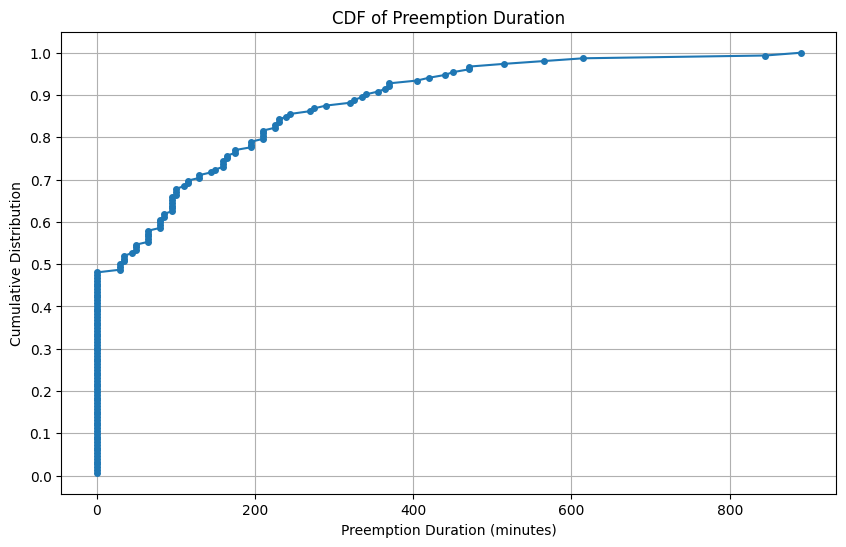

In [40]:
plot_trace_cdf("./traces/availability/1-node/aws-02-15-2023/us-east-1c_v100_1.json")

In [48]:
with open("./traces/preemption/4-node/aws-08-03-2023/us-east-1f_v100_1.json") as f1:
    f1_content = f1.read()
f1_json = json.loads(f1_content)

dummy_trace = f1_json['data']

durations = calculate_preemption_durations(dummy_trace)

data = {
    "preemption_duration": durations
}

df = pd.DataFrame(data)

df.to_csv("./us-east-1f_v100_1.csv")

In [50]:
with open("./traces/preemption/4-node/aws-08-03-2023/us-east-2a_v100_1.json") as f1:
    f1_content = f1.read()
f1_json = json.loads(f1_content)

dummy_trace = f1_json['data']

durations = calculate_preemption_durations(dummy_trace)

data = {
    "preemption_duration": durations
}

df = pd.DataFrame(data)

df.to_csv("./us-east-2a_v100_1.csv")

In [51]:
with open("./traces/preemption/4-node/aws-08-03-2023/us-west-2c_v100_1.json") as f1:
    f1_content = f1.read()
f1_json = json.loads(f1_content)

dummy_trace = f1_json['data']

durations = calculate_preemption_durations(dummy_trace)

data = {
    "preemption_duration": durations
}

df = pd.DataFrame(data)

df.to_csv("./us-west-2c_v100_1.csv")

In [49]:
with open("./traces/availability/1-node/aws-02-15-2023/us-east-1a_v100_1.json") as f2:
    f2_content = f2.read()
f2_json = json.loads(f2_content)

dummy_trace = f2_json['data']

durations = calculate_preemption_durations(dummy_trace)

data = {
    "preemption_duration": durations
}

df = pd.DataFrame(data)

df.to_csv("./us-east-1a_v100_1.csv")

In [52]:
with open("./traces/availability/1-node/aws-02-15-2023/us-east-1c_v100_1.json") as f2:
    f2_content = f2.read()
f2_json = json.loads(f2_content)

dummy_trace = f2_json['data']

durations = calculate_preemption_durations(dummy_trace)

data = {
    "preemption_duration": durations
}

df = pd.DataFrame(data)

df.to_csv("./us-east-1c_v100_1.csv")

In [53]:
with open("./traces/availability/1-node/aws-02-15-2023/us-east-2a_v100_1.json") as f2:
    f2_content = f2.read()
f2_json = json.loads(f2_content)

dummy_trace = f2_json['data']

durations = calculate_preemption_durations(dummy_trace)

data = {
    "preemption_duration": durations
}

df = pd.DataFrame(data)

df.to_csv("./us-east-2a_v100_1_1.csv")

In [54]:
with open("./traces/availability/1-node/aws-02-15-2023/us-west-2a_v100_1.json") as f2:
    f2_content = f2.read()
f2_json = json.loads(f2_content)

dummy_trace = f2_json['data']

durations = calculate_preemption_durations(dummy_trace)

data = {
    "preemption_duration": durations
}

df = pd.DataFrame(data)

df.to_csv("./us-west-2a_v100_1.csv")